In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import duckdb
connection = duckdb.connect()
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Collect

In [29]:
%%time
def get_csv(path):
    return list(map(lambda x: path+x.name,
                os.scandir(path)))



mexico =    pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_mex/meteorology/')])
altz =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_altzomoni/meteorology/')])
cham =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_chamela/meteorology/')])
herm =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_hermosillo/meteorology/')])
jur =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_juriquilla/meteorology/')])
agu =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_agsc/meteorology/')])
maz =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_maza/meteorology/')])
med =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_meda/meteorology/')])
mine =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_mine/meteorology/')])
ptom =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_ptom/meteorology/')])
sisal =     pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_sisal/meteorology/')])
sllo =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_sllo/meteorology/')])
texo =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_texo/meteorology/')])
tmix =      pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_tmix/meteorology/')])
tux =       pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_tux/meteorology/')])
morelia =   pd.concat([pd.read_csv(i, header=5, encoding='utf_8', encoding_errors='ignore') for i in get_csv('data_morelia/meteorology/')])

Wall time: 1min 29s


In [30]:
%%time
morelia['region'] = 'Morelia'
altz['region'] = 'Altzomoni'
cham['region'] = 'Chamela'
herm['region'] = 'Hermosillo'
jur['region'] = 'Juriquilla'
agu['region'] = 'Aguascalientes'
maz['region'] = 'Mazatlan'
med['region'] = 'Merida'
mine['region'] = 'Mineria'
ptom['region'] = 'Puerto Morelos'
sisal['region'] = 'Sisal'
sllo['region'] = 'Saltillo'
texo['region'] = 'Texcoco'
tmix['region'] = 'Temixco'
tux['region'] = 'Los Tuxtlas'
mexico['region'] = 'Mexico'

df = pd.concat([morelia, altz, cham, herm, jur, agu, maz, med, mine, ptom, sisal, sllo, texo, tmix, tux, mexico])
df = df[df.TIMESTAMP != 'yyyy-mm-dd HH:MM:SS'].copy()
df = df.astype({'TIMESTAMP': 'datetime64[ns]',
	            'Temp_Avg': np.float32,
                'RH_Avg': np.float32,
                'WSpeed_Avg': np.float32,
                'WSpeed_Max': np.float32,
                'WDir_Avg': np.float32,
                'WDir_SD': np.float32,
                'Rain_Tot': np.float32,
                'Press_Avg': np.float32,
                'Rad_Avg': np.float32,
                'region': 'category',
                'Visibility': np.float32,
                'Visibility_Avg': np.float32,})

Wall time: 8min 27s


In [31]:
df = df.reset_index(drop=True)
df.head()

,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,region,Visibility,Visibility_Avg
0,2015-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
1,2015-08-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
2,2015-08-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
3,2015-08-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN
4,2015-08-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Morelia,NaN,NaN


In [32]:
df.to_parquet('temp.parquet')

# Clean

In [3]:
sql_command = '''
with t1 as (
    select 
        region, 
        min(TIMESTAMP),
        max(TIMESTAMP),
        from df
    group by region),

t2 as (
    select 
        region,
        date_trunc('month', TIMESTAMP) as month
        from df

    group by region, date_trunc('month', TIMESTAMP)
    order by region, date_trunc('month', TIMESTAMP)
) 
select * from t2
'''
dft = connection.execute(sql_command).df()
dft['lag'] = dft.month - dft.month.shift(1)
td = pd.Timedelta(31, "d")
dft[dft.lag > td]

CatalogException: Catalog Error: Table with name df does not exist!
Did you mean "pg_am"?

In [6]:
%%time
df = connection.execute('''
with df as (
    select row_number() over(partition by region) as id, * from read_parquet(['temp.parquet'])
    where Temp_Avg is not NULL
)

select * from df
where id  < 250000
''').df().drop(columns=['id'])
df

Wall time: 24.4 s


,TIMESTAMP,Temp_Avg,RH_Avg,WSpeed_Avg,WSpeed_Max,WDir_Avg,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,region,Visibility,Visibility_Avg
0,2018-04-05 19:09:00,27.260000,22.959999,3.878,4.68,10.110000,12.450000,0.0,871.914978,-1.127,Temixco,NaN,NaN
1,2018-04-05 19:10:00,27.200001,22.980000,4.498,5.55,23.600000,10.730000,0.0,871.841003,-1.230,Temixco,NaN,NaN
2,2018-04-05 19:11:00,27.209999,23.100000,3.890,4.46,23.030001,12.660000,0.0,871.747986,-1.196,Temixco,NaN,NaN
3,2018-04-05 19:12:00,27.250000,22.920000,4.713,7.21,9.050000,22.299999,0.0,871.898010,-1.196,Temixco,NaN,NaN
4,2018-04-05 19:13:00,27.299999,22.049999,6.595,7.67,334.299988,9.890000,0.0,871.877991,-1.845,Temixco,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3999979,2020-02-12 12:59:00,27.110001,77.260002,7.630,8.43,152.699997,3.741000,0.0,1014.349976,883.000,Puerto Morelos,NaN,NaN
3999980,2020-02-12 13:00:00,27.139999,76.739998,8.750,8.91,150.600006,3.382000,0.0,1014.117981,884.000,Puerto Morelos,NaN,NaN
3999981,2020-02-12 13:01:00,27.090000,76.820000,7.997,8.25,148.100006,1.081000,0.0,1014.132019,898.000,Puerto Morelos,NaN,NaN
3999982,2020-02-12 13:02:00,27.080000,76.949997,8.330,9.18,147.300003,1.406000,0.0,1014.151978,891.000,Puerto Morelos,NaN,NaN


In [7]:
df = df.astype({'region': 'category'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999984 entries, 0 to 3999983
Data columns (total 13 columns):
 #   Column          Dtype         
---  ------          -----         
 0   TIMESTAMP       datetime64[ns]
 1   Temp_Avg        float32       
 2   RH_Avg          float32       
 3   WSpeed_Avg      float32       
 4   WSpeed_Max      float32       
 5   WDir_Avg        float32       
 6   WDir_SD         float32       
 7   Rain_Tot        float32       
 8   Press_Avg       float32       
 9   Rad_Avg         float32       
 10  region          category      
 11  Visibility      float32       
 12  Visibility_Avg  float32       
dtypes: category(1), datetime64[ns](1), float32(11)
memory usage: 202.2 MB


In [8]:
a = sns.color_palette("magma", 9)
a

[(0.078815, 0.054184, 0.211667),
 (0.232077, 0.059889, 0.437695),
 (0.390384, 0.100379, 0.501864),
 (0.550287, 0.161158, 0.505719),
 (0.716387, 0.214982, 0.47529),
 (0.868793, 0.287728, 0.409303),
 (0.967671, 0.439703, 0.35981),
 (0.994738, 0.62435, 0.427397),
 (0.99568, 0.812706, 0.572645)]

## Region distribution

In [29]:
df.region.astype(str).unique()

array(['Temixco', 'Juriquilla', 'Mineria', 'Morelia', 'Texcoco',
       'Chamela', 'Aguascalientes', 'Hermosillo', 'Mazatlan', 'Saltillo',
       'Merida', 'Sisal', 'Los Tuxtlas', 'Altzomoni', 'Mexico',
       'Puerto Morelos'], dtype=object)

In [41]:
def plot_distribution(dft):
    dft = dft.astype({'region' : str})
    fig, axs = plt.subplots(3, 3, figsize=(12, 8), dpi=150)
    cols = dft.columns[1:]
    n = 0
    for i in range(3):
        for j in range(3):
            sns.histplot(data=dft[
                                (dft[cols[n]].between(dft[cols[n]].quantile(0.01),
                                                    dft[cols[n]].quantile(0.99),
                                                    ))], 
                        x=cols[n], bins=100, ax=axs[i, j], color=a[n], stat='density', hue='region')
            
            box = axs[i, j].get_position()
            axs[i, j].set_position([box.x0 + j * 0.05, box.y0 - i * 0.05, box.width, box.height])
            n+=1

Temp_Avg 0.005 - 0.995  
RH_avg 1-99  
WSpeed_AVG 0 - 0.995  
WSpeed_Max 0 - 0.995  
WDir_AVG 0.001 - 359.999  
**WDir_SD 0.001 - 359.999**  
Rain_Tot 0 - inf  
Press_Avg Z_value  
Rad_Avg > 0.001  (replace to NULL)

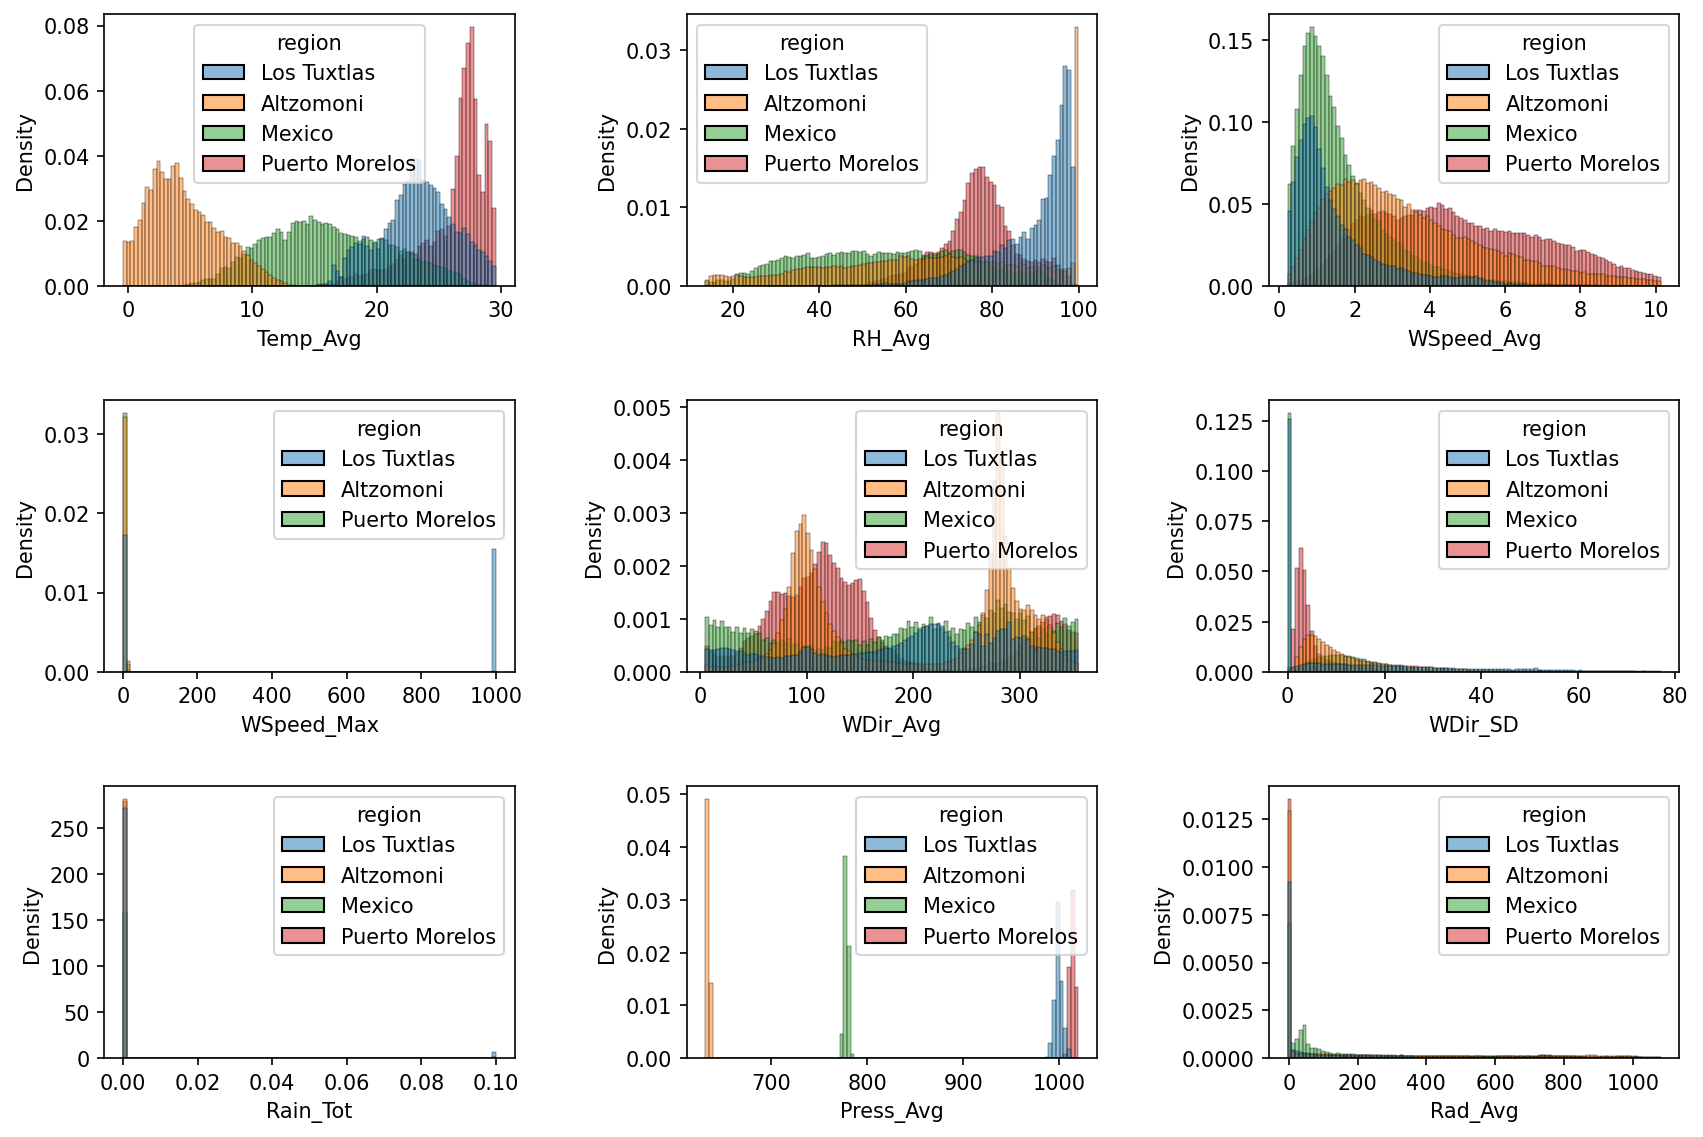

In [47]:
plot_distribution(df[df.region.isin({'Los Tuxtlas', 'Altzomoni', 'Mexico', 'Puerto Morelos'})].copy())

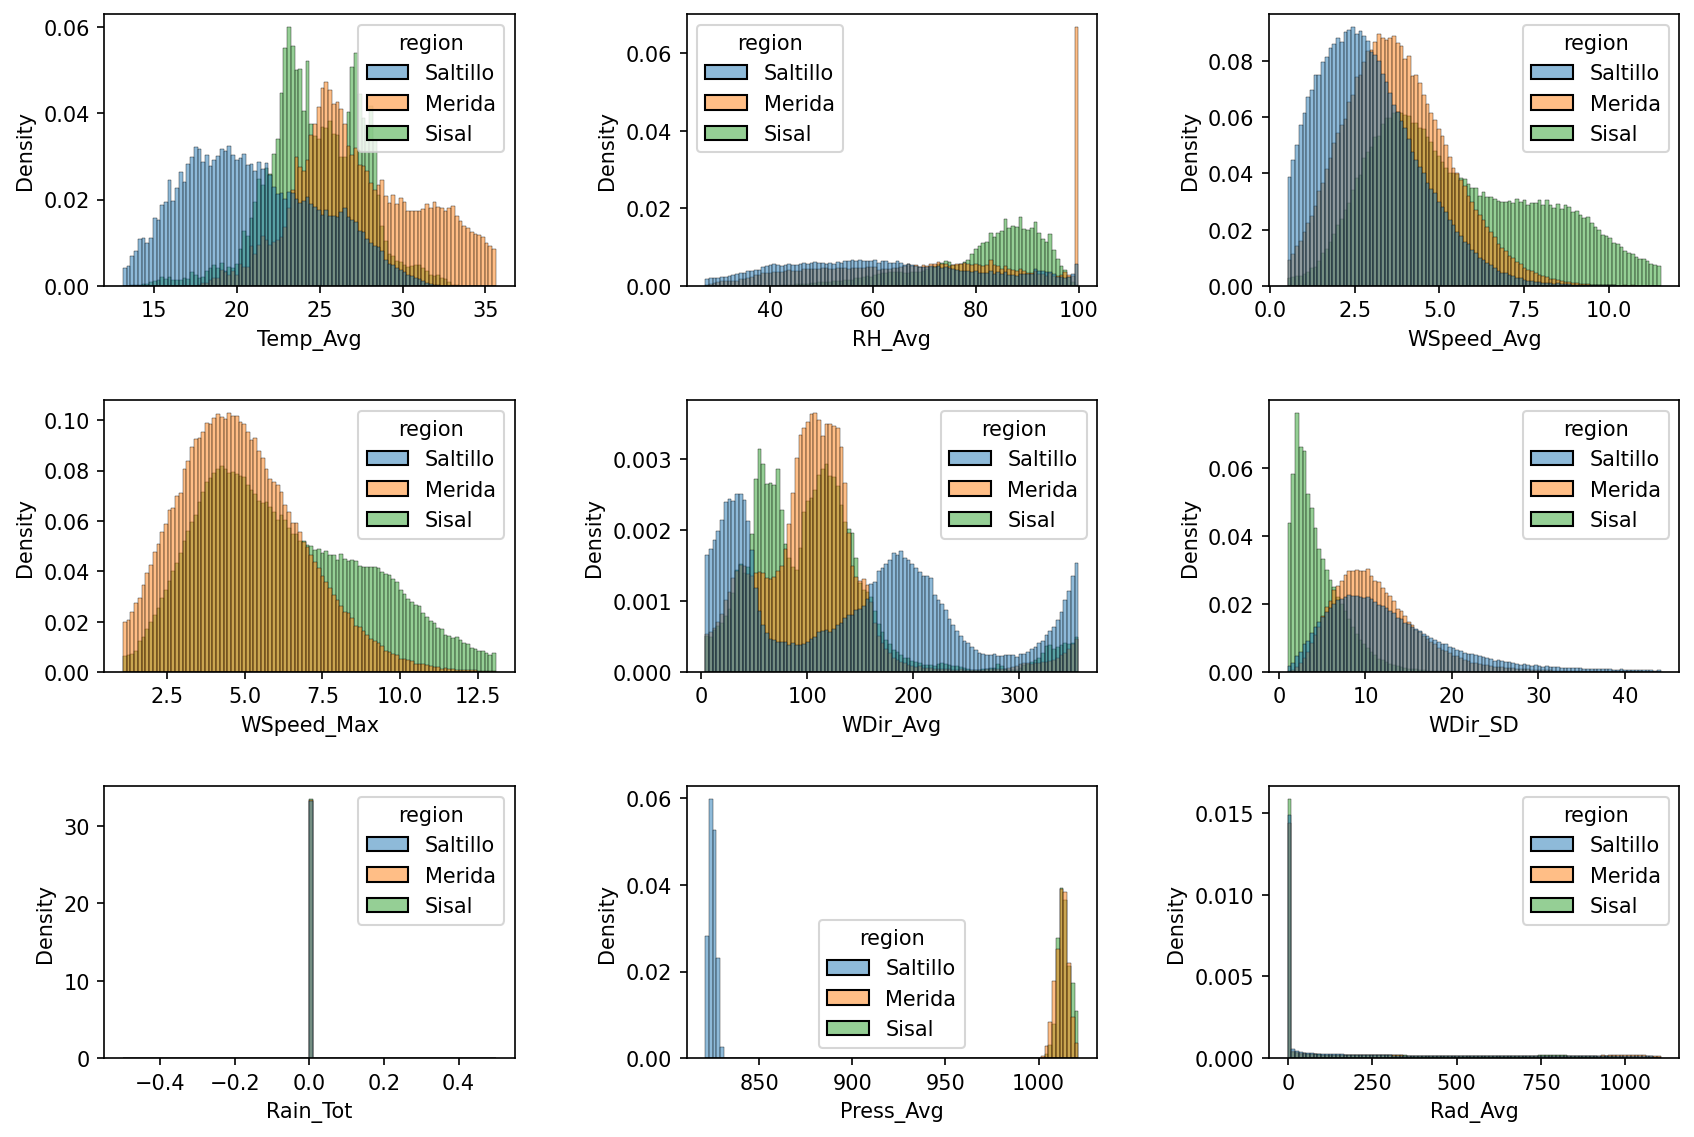

In [46]:
plot_distribution(df[df.region.isin({'Saltillo', 'Merida', 'Sisal'})].copy())

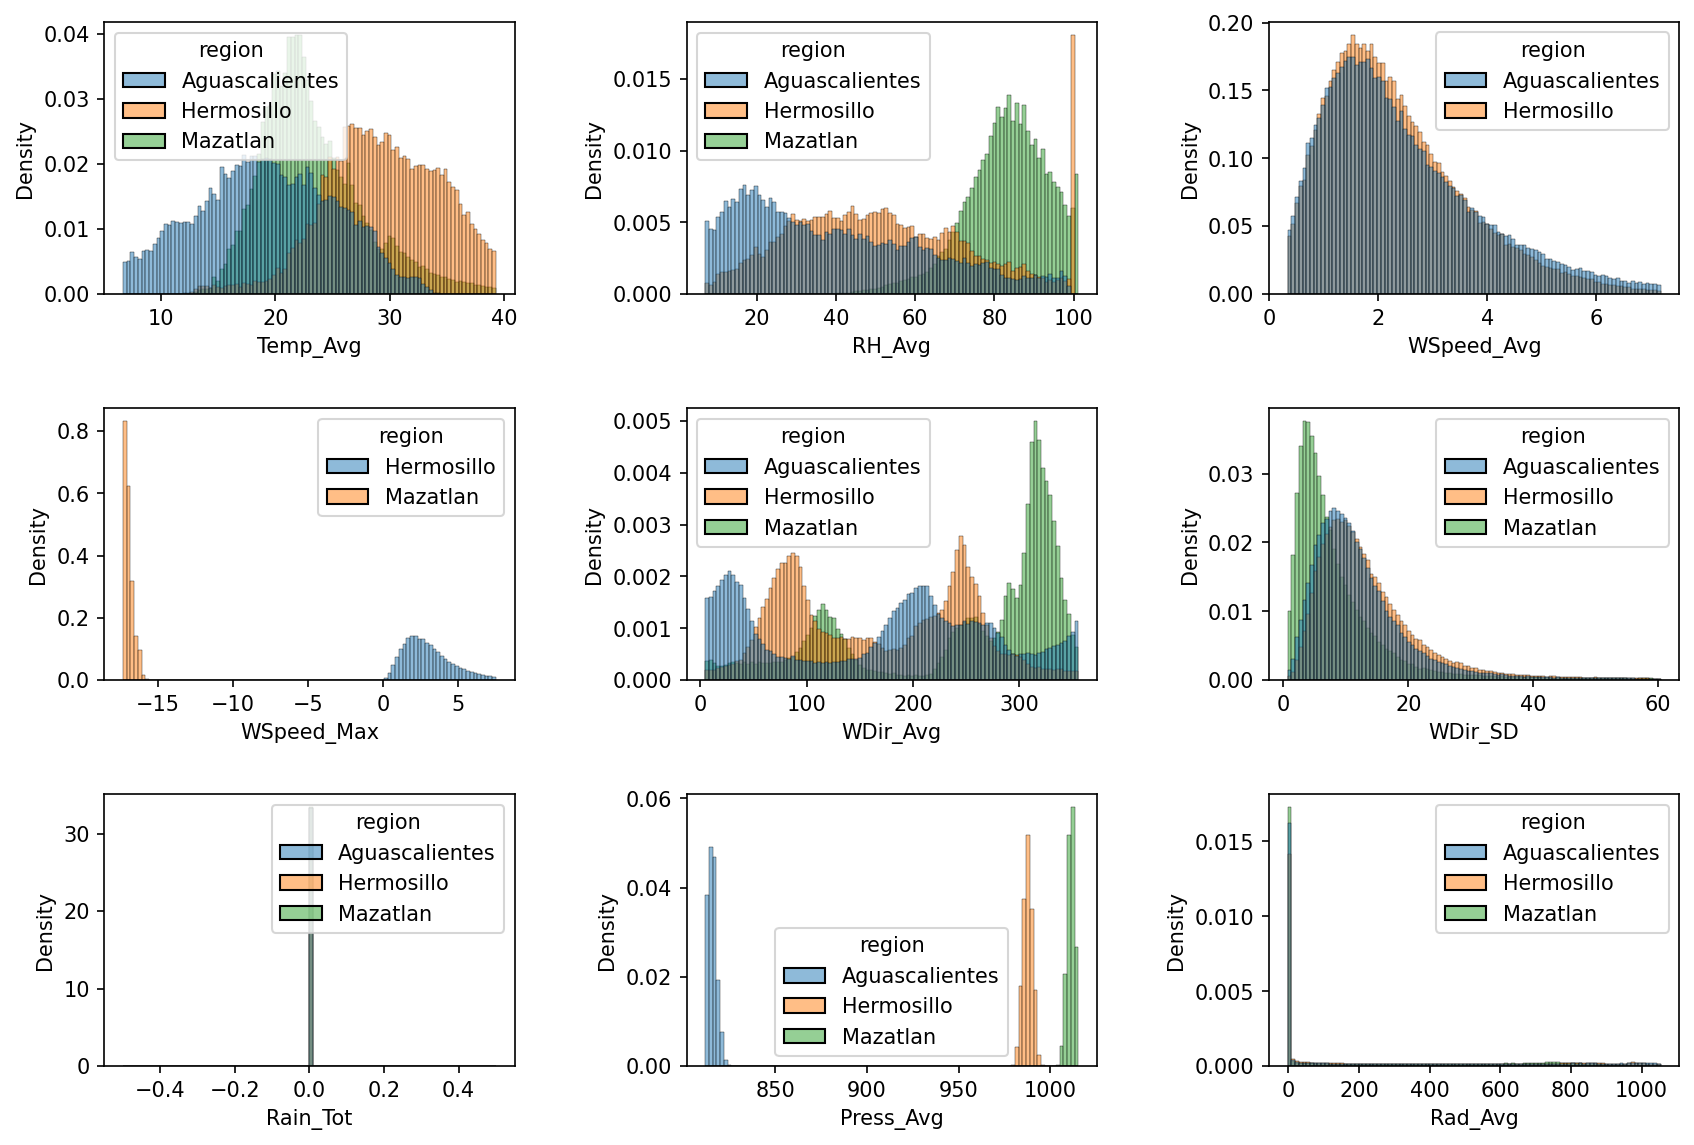

In [44]:
plot_distribution(df[df.region.isin({'Aguascalientes', 'Hermosillo', 'Mazatlan',})].copy())

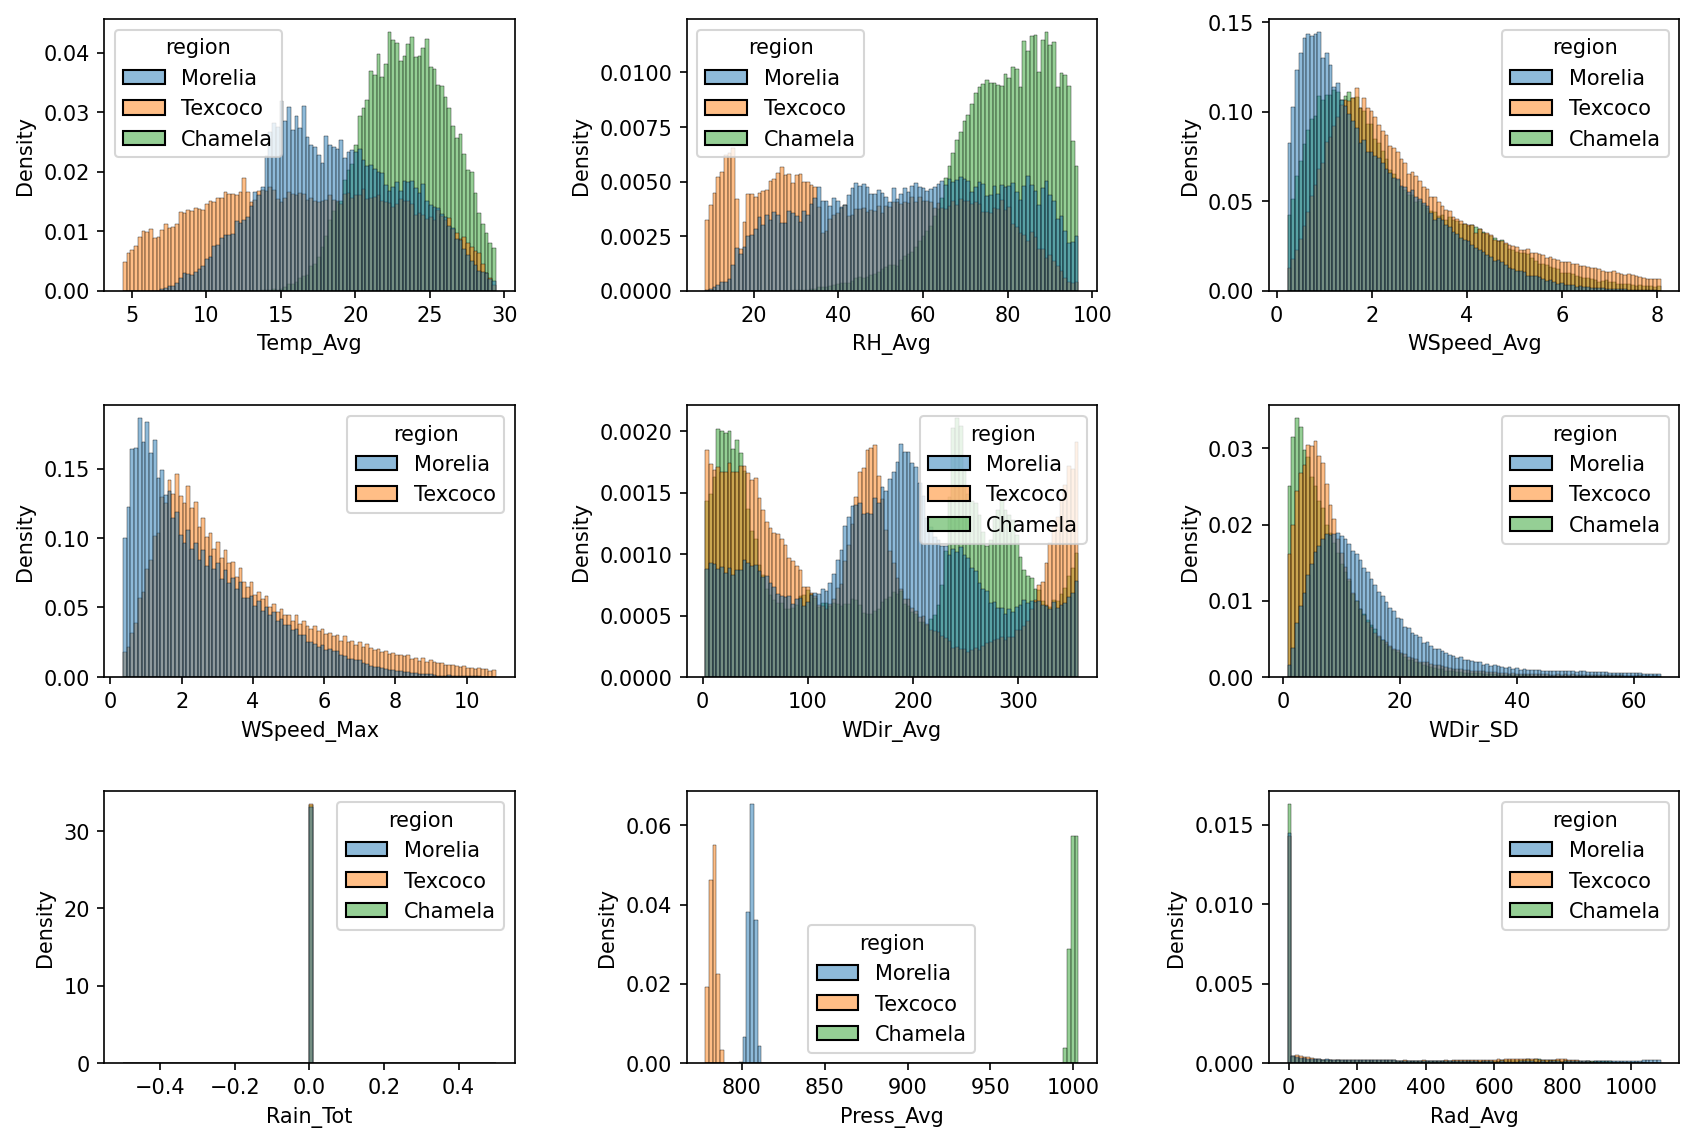

In [43]:
plot_distribution(df[df.region.isin({'Morelia', 'Texcoco', 'Chamela',})].copy())

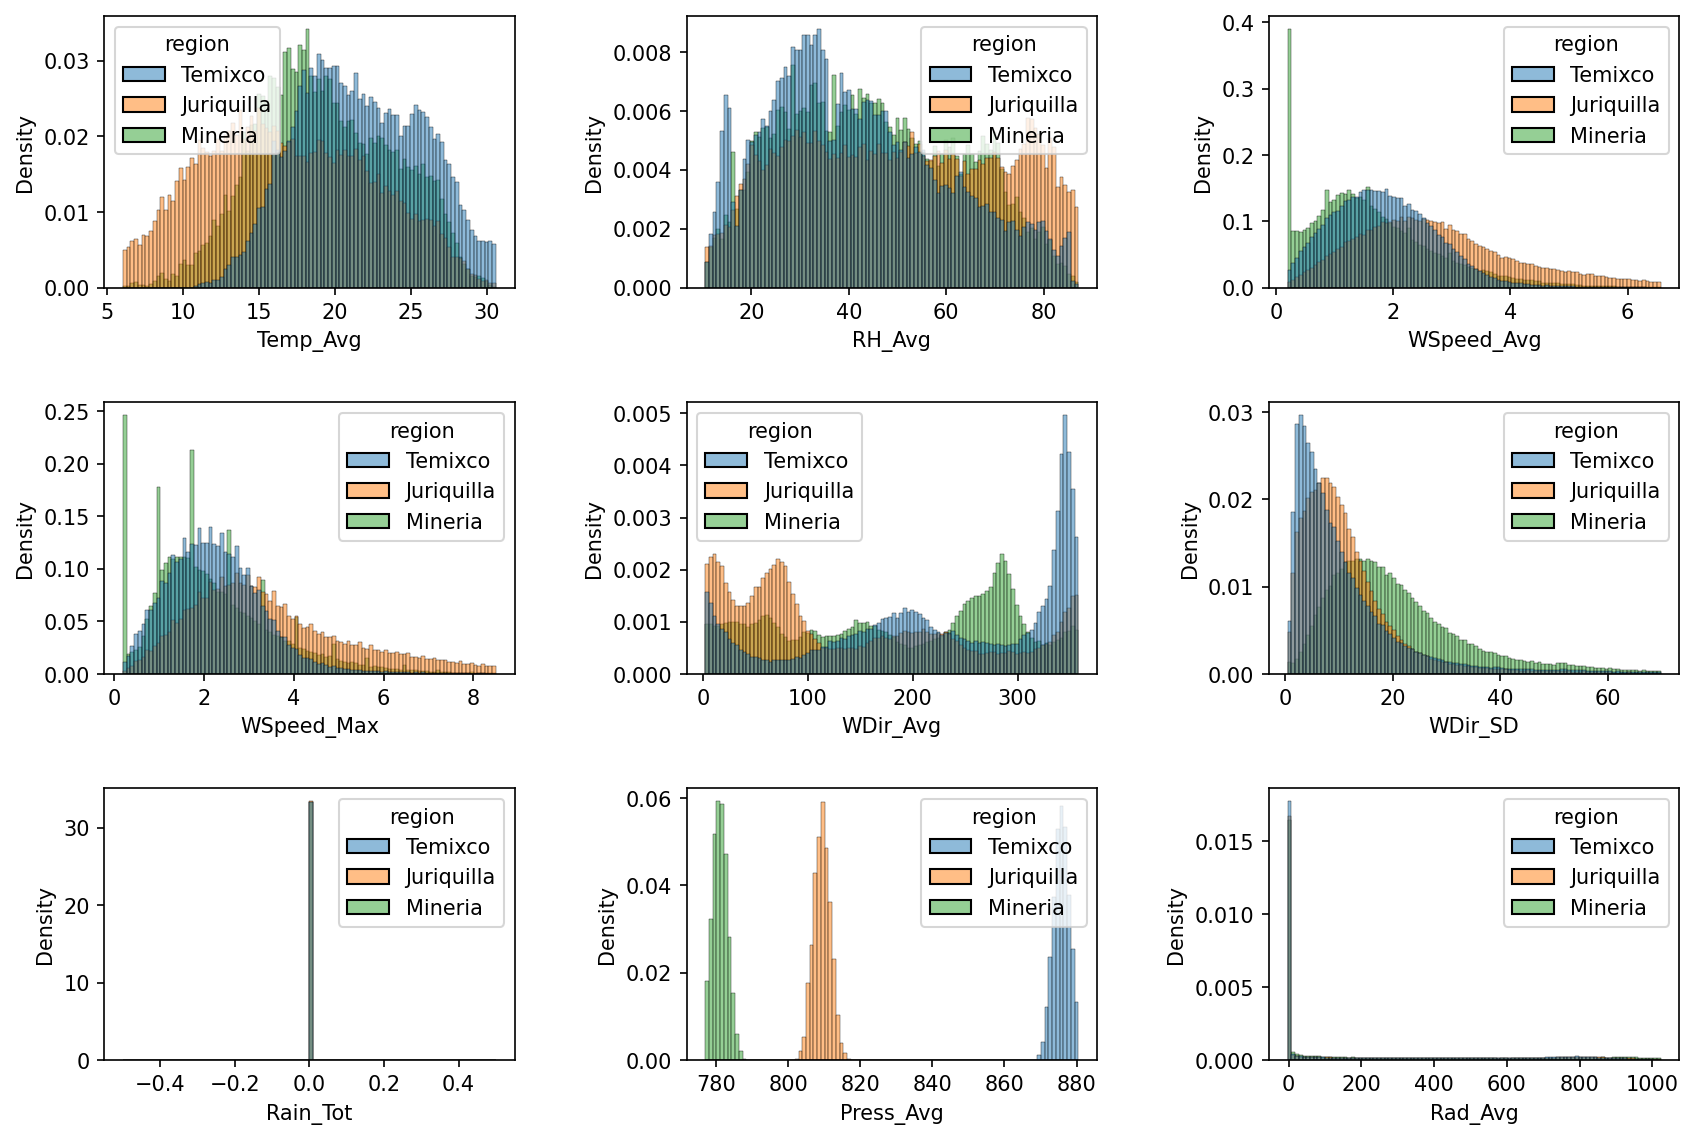

In [42]:
plot_distribution(df[df.region.isin({'Temixco', 'Juriquilla', 'Mineria'})].copy())

# Total clean

Temp_Avg 0.005 - 0.995  
RH_avg 1-99  
WSpeed_AVG 0 - 0.995  
WSpeed_Max 0 - 0.995  
WDir_AVG 0.001 - 359.999  
**WDir_SD 0.001 - 359.999**  
Rain_Tot 0 - inf  
Press_Avg Z_value  
Rad_Avg > 0.001  (replace to NULL)

In [6]:
%%time
from scipy import stats

def q005(arr):
    return arr.quantile(0.005)

def q01(arr):
    return arr.quantile(0.01)

def q995(arr):
    return arr.quantile(0.995)

df = pd.read_parquet('temp.parquet')
dft = df.groupby('region').agg(WSpeed_AVG_q995=('WSpeed_Avg', q995),
                            WSpeed_Max_q995=('WSpeed_Max', q995),
                            press_avg=('Press_Avg', 'mean'),
                            press_std=('Press_Avg', 'std'),
                            temp_avg=('Temp_Avg', 'mean'),
                            temp_std=('Temp_Avg', 'std'),
                            ).reset_index()

Wall time: 23.2 s


In [7]:
dft

,region,WSpeed_AVG_q995,WSpeed_Max_q995,press_avg,press_std,temp_avg,temp_std
0,Aguascalientes,7.690,9.680000,816.817688,2.364958,18.908230,5.651476
1,Altzomoni,13.300,16.790001,634.138000,4.606856,5.125785,2.894821
2,Chamela,8.820,10.990000,990.198730,65.683496,25.099041,6.207235
3,Hermosillo,7.258,9.310000,988.529053,3.288344,24.809774,9.381442
4,Juriquilla,8.340,10.720000,809.061523,2.401796,18.676325,5.315475
5,Los Tuxtlas,5.780,1000.000000,998.861877,4.417763,23.791063,3.535697
6,Mazatlan,13.870,9.140000,1010.089722,2.392358,24.519390,11.006781
7,Merida,8.250,10.490000,1012.964783,3.585219,27.104519,4.022672
8,Mexico,6.168,8.430000,778.043762,7.780187,16.877085,4.601780
9,Mineria,5.337,6.950000,781.097351,2.042366,18.036591,4.157032


In [8]:
%%time
df = connection.execute('''
with qz as (select *, 
    (df.Press_Avg - dft.press_avg)/dft.press_std as press_zvalue, 
    (df.Temp_Avg - dft.temp_avg)/dft.temp_std as temp_zvalue, 
    
    from df

    left join dft on dft.region = df.region)

select 
    TIMESTAMP,
    region,
    CASE when 
        ( 
            (temp_zvalue between -3 and 3) or (Temp_Avg is NULL)
        )
        then Temp_Avg else NULL
    END as Temp_Avg,

    CASE when
        (
            (WSpeed_AVG between 0 and WSpeed_AVG_q995) or (WSpeed_AVG is NULL)
        )
        then WSpeed_AVG else NULL
    END as WSpeed_AVG,

    CASE when
        (
            (WSpeed_Max between 0 and WSpeed_Max_q995) or (WSpeed_Max is NULL)
        )
        then WSpeed_Max else NULL
    END as WSPeed_Max,

    CASE when
        (
            (WDir_SD between 0.001 and 359.999) or (WDir_SD is NULL)
        )
        then WDir_SD else NULL
    END as WDir_SD,

    CASE when
        (
            (Rain_Tot >= 0) or (Rain_Tot is NULL)
        )
        then Rain_Tot else NULL
    END as Rain_Tot,

    CASE when
        (
            (press_zvalue between -3 and 3) or (Press_Avg is NULL)
        )
        then Press_Avg else NULL
    END as Press_Avg,

    CASE when
        (
            (Rad_Avg > 0.001) or (Rad_Avg is NULL)
        )
        then Rad_Avg else NULL
    END as Rad_Avg,

    CASE when
        (
            (Visibility_Avg between 500 and 19000) or (Visibility_Avg is NULL)
        )
        then Visibility_Avg else NULL
    END as Visibility_Avg,

    CASE when
        (
            (Visibility between 500 and 19000) or (Visibility is NULL)
        )
        then Visibility else NULL
    END as Visibility,

    CASE when
        (
            (RH_Avg between 1 and 99) or (RH_Avg is NULL)
        ) 
        then RH_Avg else NULL
    END as RH_Avg,

    CASE when 
        (
            (WDir_AVG between 0.001 and 359.999) or (WDir_AVG is NULL)
        )
        then WDir_AVG else NULL
    END as WDir_AVG
    

from qz
''').df()

Wall time: 34.7 s


In [9]:
df.describe()

,Temp_Avg,WSpeed_AVG,WSPeed_Max,WDir_SD,Rain_Tot,Press_Avg,Rad_Avg,Visibility_Avg,Visibility,RH_Avg,WDir_AVG
count,5.079382e+07,4.975630e+07,3.539439e+07,5.051151e+07,5.167146e+07,4.974071e+07,2.859819e+07,230778.000000,7965.000000,4.935768e+07,5.065202e+07
mean,1.144184e+01,2.252791e+00,1.188550e+01,1.050447e+01,1.667776e-03,3.455849e+02,4.115014e+02,11741.947266,5606.735352,4.350861e+01,1.439605e+02
std,1.050318e+01,1.932091e+00,9.480959e+01,1.133861e+01,1.112994e+00,4.205222e+02,3.449702e+02,4861.594238,2082.726318,2.839321e+01,9.999560e+01
min,-8.500000e+00,0.000000e+00,0.000000e+00,2.000000e-03,0.000000e+00,6.204000e+02,2.000000e-03,500.100006,510.600006,1.000000e+00,1.000000e-03
25%,1.566000e+01,1.295000e+00,1.700000e+00,5.436000e+00,0.000000e+00,8.045090e+02,8.270000e+01,8184.750000,3987.000000,4.309000e+01,8.030000e+01
50%,2.143000e+01,2.267000e+00,2.950000e+00,9.610000e+00,0.000000e+00,8.265330e+02,3.552000e+02,12259.950195,4544.000000,6.598000e+01,1.558000e+02
75%,2.587000e+01,3.730000e+00,4.830000e+00,1.569000e+01,0.000000e+00,1.000816e+03,7.255000e+02,15914.574219,7999.000000,8.160000e+01,2.633000e+02
max,5.753000e+01,1.452000e+01,1.000000e+03,1.039000e+02,7.999000e+03,1.025207e+03,1.650000e+03,19000.000000,7999.000000,9.900000e+01,3.599000e+02


In [10]:
df.to_parquet('cleaned.parquet')

# Data analyse, filling some data

<AxesSubplot:>

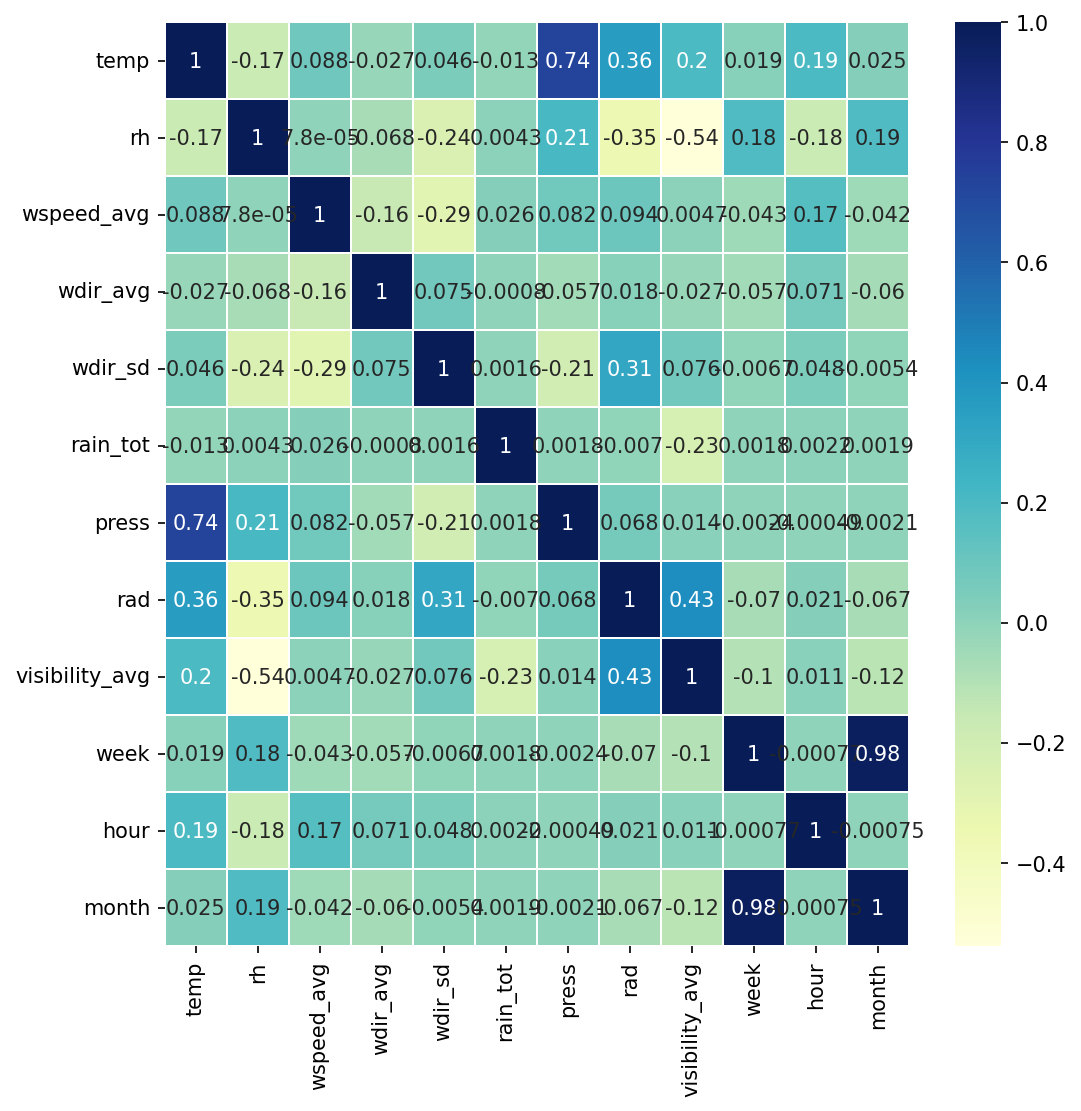

In [2]:
sql_command = '''
with df as (
    select 
        date_trunc('hour', TIMESTAMP) as time,
        Temp_Avg,
        region,
        RH_Avg,
        WSpeed_Avg,
        WDir_Avg,
        WDir_SD,
        Rain_Tot,
        Press_Avg,
        Rad_Avg,
        Visibility_Avg
    
    from read_parquet(['cleaned.parquet'])
    ),

hour as (
        select 
        time,
        region, 
        avg(Temp_Avg) as temp,
        avg(RH_Avg) as rh,
        avg(WSpeed_Avg) as wspeed_avg,
        avg(WDir_Avg) as wdir_avg,	
        avg(WDir_SD) as wdir_sd,
        avg(Rain_Tot) as rain_tot,
        avg(Press_Avg) as press,
        avg(Rad_Avg) as rad,
        avg(Visibility_Avg) as visibility_avg

    from df
        group by time, region
    )

select *, date_part('week', time) as week, date_part('hour', time) as hour, date_part('month', time) as month from hour
'''
df = connection.execute(sql_command).df()
df = df[df.isna().sum(axis=1) < 4].copy()
df = df.reset_index(drop=True)
corrM = df.corr()
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
sns.heatmap(corrM, annot=True, cmap="YlGnBu", linewidths=0.1,)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 849608 entries, 0 to 849607
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   time            849608 non-null  datetime64[ns]
 1   region          849608 non-null  object        
 2   temp            839657 non-null  float64       
 3   rh              823204 non-null  float64       
 4   wspeed_avg      830185 non-null  float64       
 5   wdir_avg        846564 non-null  float64       
 6   wdir_sd         849056 non-null  float64       
 7   rain_tot        843761 non-null  float64       
 8   press           813263 non-null  float64       
 9   rad             577910 non-null  float64       
 10  visibility_avg  6094 non-null    float64       
 11  week            849608 non-null  int64         
 12  hour            849608 non-null  int64         
 13  month           849608 non-null  int64         
dtypes: datetime64[ns](1), float64(9), in

## Distribution of different variables

<AxesSubplot:xlabel='temp', ylabel='region'>

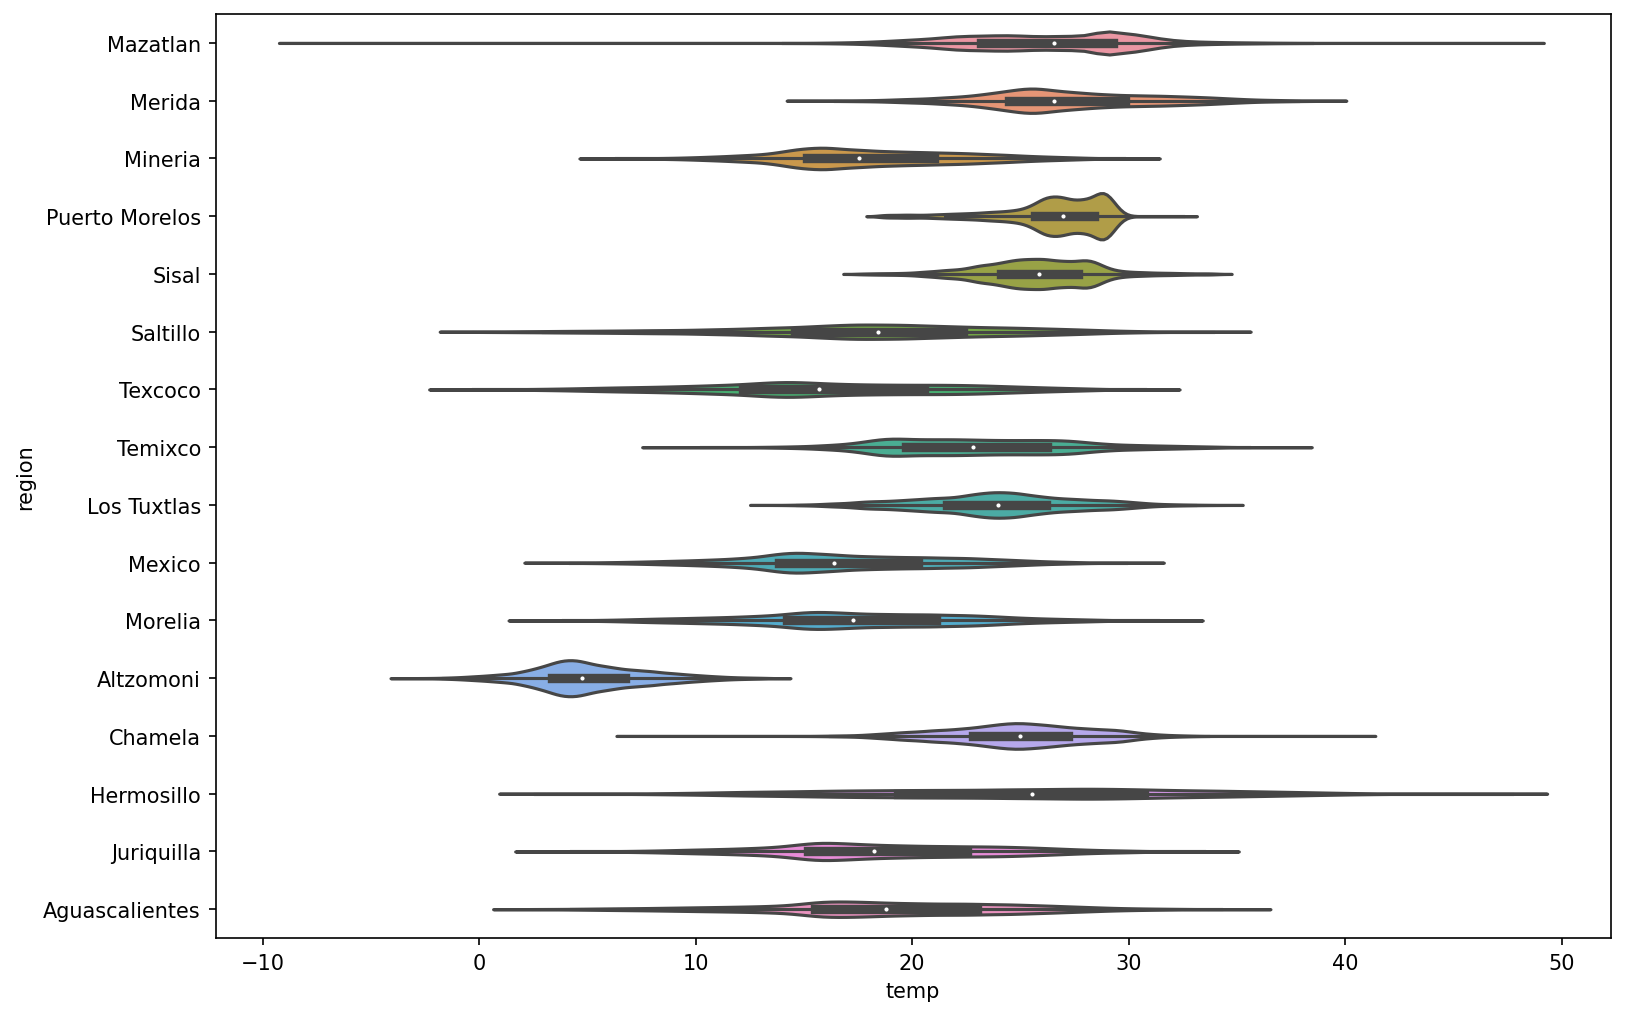

In [4]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
sns.violinplot(data=df, x='temp', y='region', ax=ax)

<AxesSubplot:xlabel='press', ylabel='region'>

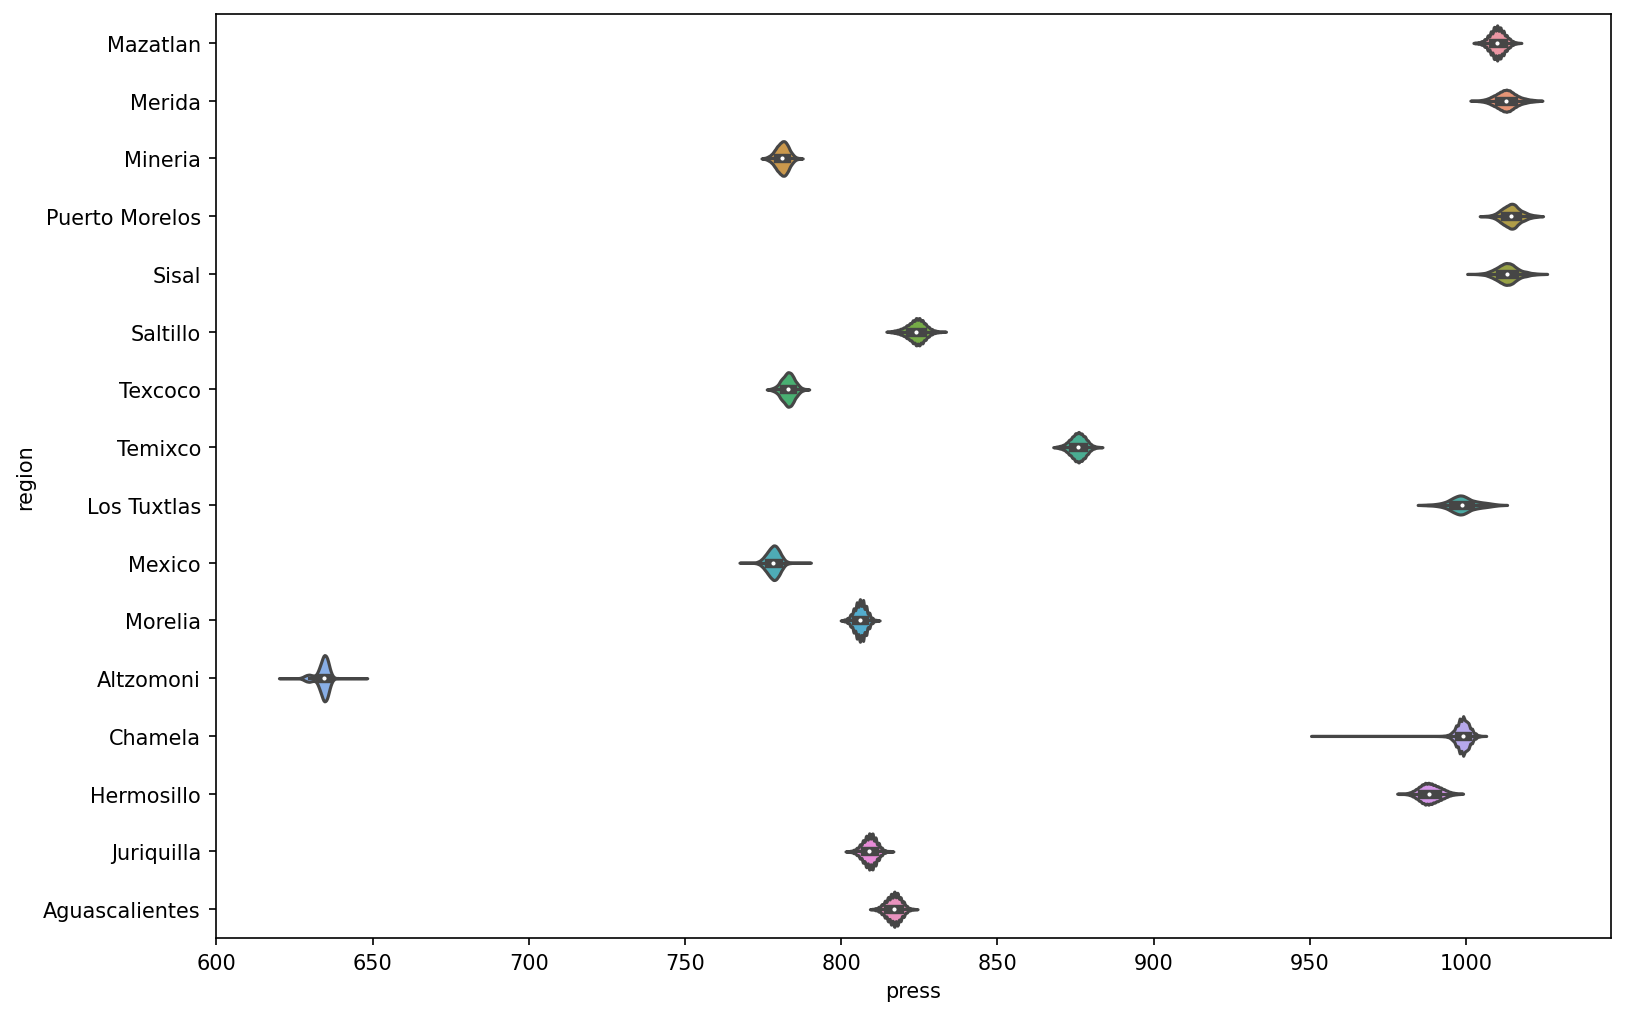

In [5]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=150)
dft = df[~((df.press < 950) & (df.region == 'Chamela'))]
sns.violinplot(data=dft, x='press', y='region', ax=ax)

## Seasonality 

In [6]:
sql_command = '''

with df as (
    select 
    date_part('hour', TIMESTAMP) as hour, 
    date_part('month', TIMESTAMP::date) as month, 
    * from read_parquet(['cleaned.parquet'])
    ),


    
t1 as (
    select 
        hour,
        month, 
        region, 
        avg(Temp_Avg) as temp,
        avg(RH_Avg) as rh,
        avg(WSpeed_Avg) as wspeed_avg,
        avg(WDir_Avg) as wdir_avg,	
        avg(WDir_SD) as wdir_sd,
        avg(Rain_Tot) as rain_tot,
        avg(Press_Avg) as press,
        avg(Rad_Avg) as rad,
        avg(Visibility_Avg) as visibility_avg
        from df group by region, month, hour
        )

select 
    month * 24 + hour - 24 as x_axis, 
    * 
    from t1 order by month, hour
'''
df = connection.execute(sql_command).df()

Seasonalyty of temperature during a day in different months.

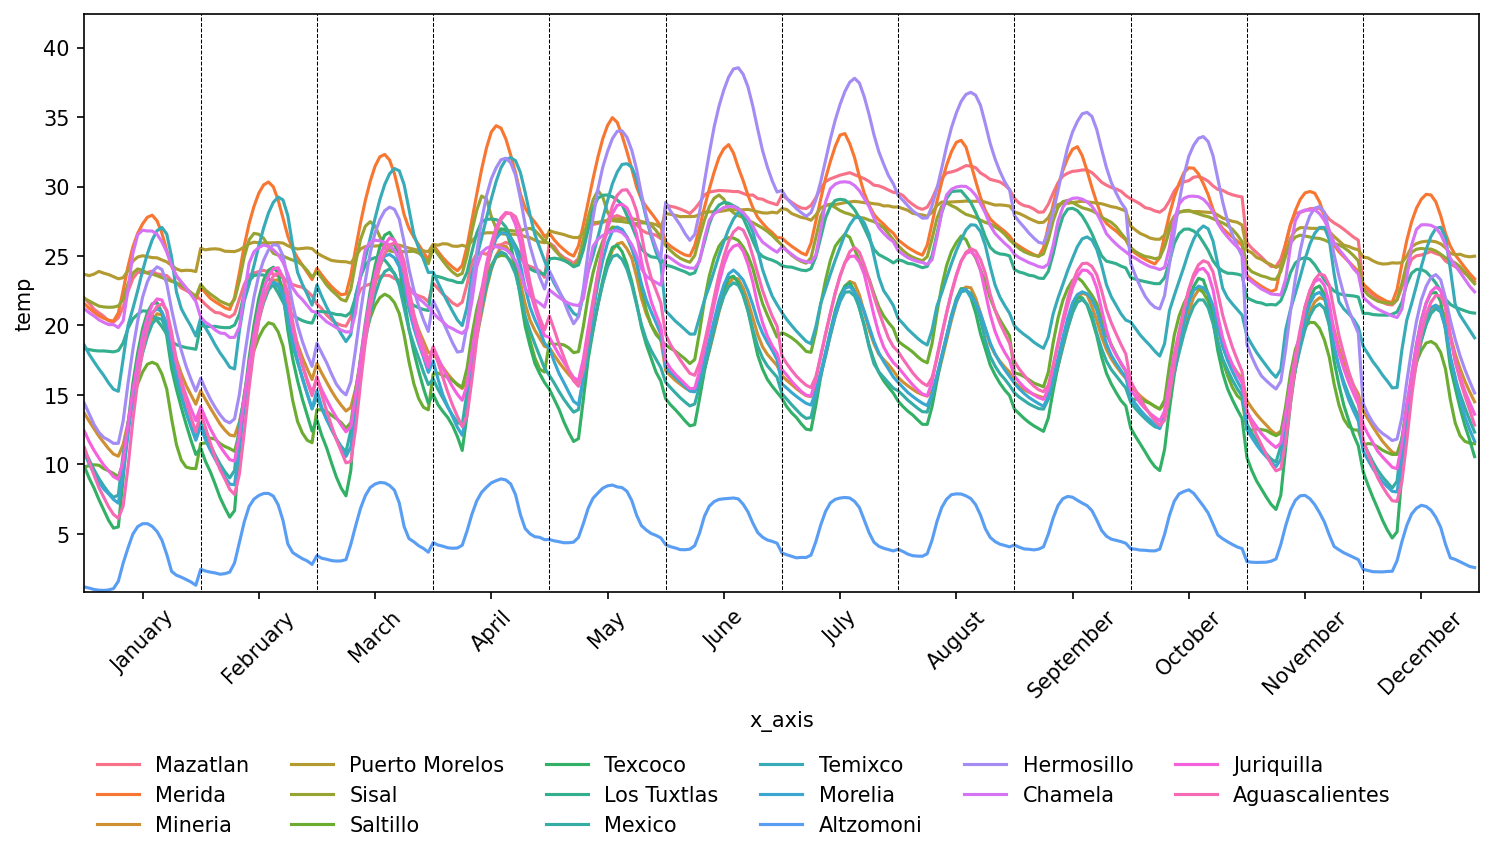

In [7]:
def show_day_month_seasonality(y_axis='temp'):
    fig, ax = plt.subplots(1, 1, figsize=(12, 5), dpi=150)
    sns.lineplot(data = df, x='x_axis', y=y_axis, hue='region', ax=ax)
    ax.set_xticks([24*i - 12 for i in range(1, 13)])
    ax.set_xticklabels(['January', 'February', 
                        'March', 'April', 'May', 
                        'June', 'July', 'August', 
                        'September', 'October', 
                        'November', 'December'], rotation=45);

    ax.vlines([i*24 for i in range(1, 13)], [-1e6]*12, [1e6]*12, linestyles='--', color='black', linewidth=0.5)
    ax.set_xlim([0, 24*12])
    ax.set_ylim([min(df[y_axis].min()*0.9, df[y_axis].min()*1.1), 
                max(df[y_axis].max()*0.9, df[y_axis].max()*1.1),])
    
    ax.legend(ncol=6, bbox_to_anchor = [0.95, -0.25], frameon=False)

show_day_month_seasonality('temp')

# Temperature

In [8]:
sql_command = '''
with df as (
    select 
    date_part('hour', TIMESTAMP) as hour, 
    * from read_parquet(['cleaned.parquet'])
    ),
    
t1 as (
    select 
    region,
    date_trunc('month', TIMESTAMP) as month,
    avg(Temp_Avg) as temp 
    from df where hour in (13, 14)
    group by date_trunc('month', TIMESTAMP), region
)

select * from t1
'''
df = connection.execute(sql_command).df()
df.head()

,region,month,temp
0,Mazatlan,2020-10-01,33.902206
1,Mazatlan,2020-11-01,27.802086
2,Mazatlan,2020-12-01,23.773191
3,Mazatlan,2021-01-01,22.832183
4,Mazatlan,2021-02-01,23.693489


<AxesSubplot:xlabel='month', ylabel='temp'>

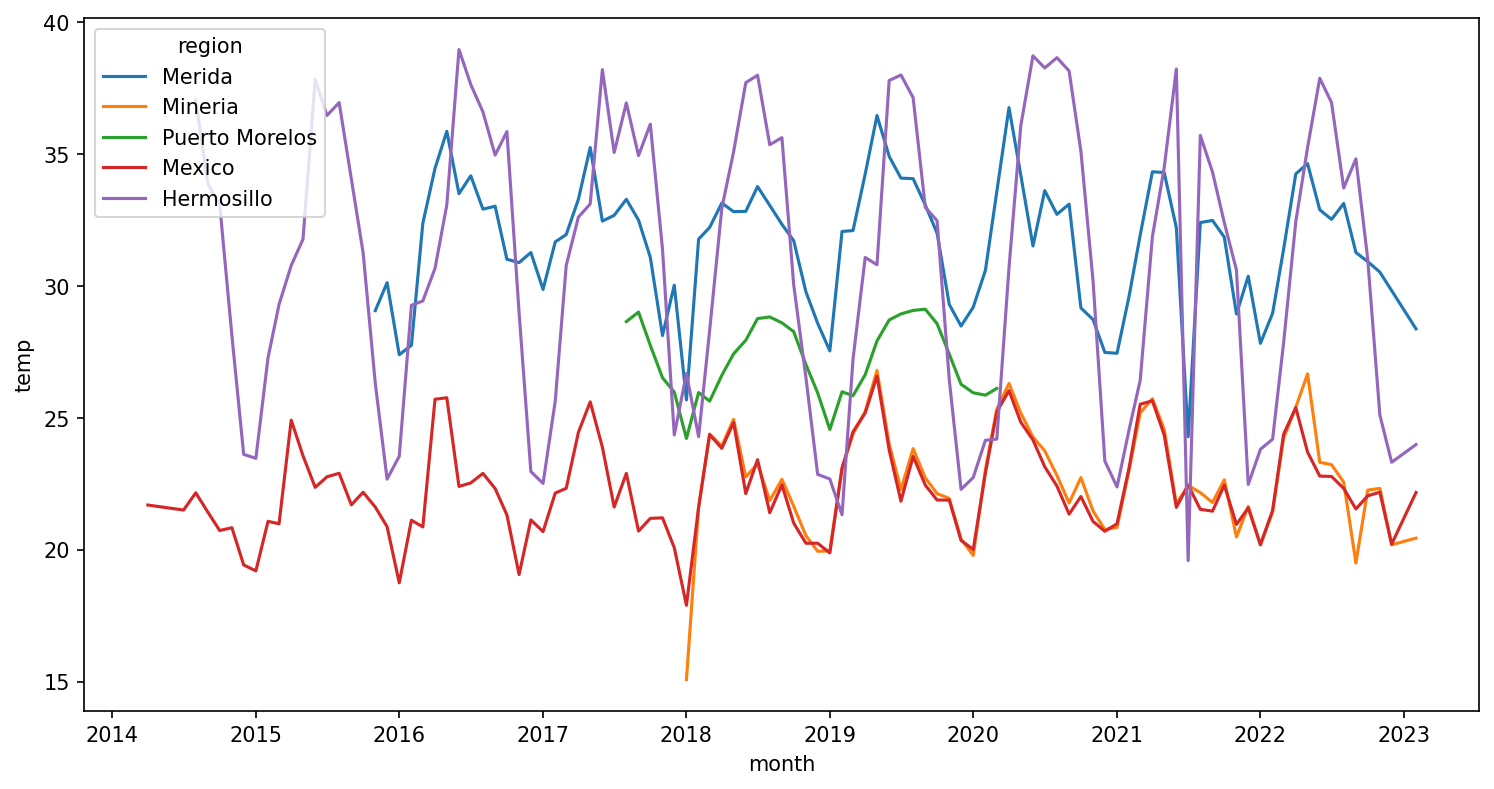

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=150)
sns.lineplot(data=df[df.region.isin({'Mexico', 'Hermosillo', 'Merida', 'Mineria', 'Puerto Morelos'})], x='month', y='temp', hue='region', ax=ax)

In [10]:
def get_whole_period(region, years):
    dft = df.loc[df.region == region, ['temp', 'month']].dropna()
    dft = dft[dft.month <= '2023-01-01']
    dft['year'] = dft.month.dt.year
    dft = dft.sort_values('month')
    dy = min((dft.year.max() - dft.year.min()), years)
    dft = dft[dft.month >= (dft.month.max() - pd.DateOffset(years=dy))]
    return dft.drop(columns='year')


def make_seasonal(region='Mexico', years=15):
    dft = get_whole_period(region, years)
    dft.index = pd.to_datetime(dft.index)
    dft = dft.set_index('month')
    sd = seasonal_decompose(dft.temp)
    return sd


def calc_index(sd):
    dft = pd.DataFrame(sd.trend.dropna()).reset_index()
    reg = LinearRegression().fit(np.arange(sd.trend.dropna().shape[0])[:, np.newaxis], sd.trend.dropna())
    return reg.coef_


for region in df.region.unique():
    years = 5
    try:
        sd = make_seasonal(region, years)
        print(region, calc_index(sd))
    except Exception as e:
        pass#print(region)

Merida [-0.02884745]
Mineria [-0.0191576]
Puerto Morelos [0.02702655]
Temixco [0.00187031]
Mexico [-0.00123275]
Morelia [0.0065653]
Altzomoni [-0.00517291]
Hermosillo [-0.00085592]
